In [1]:
import sklearn
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D,
                                     Flatten, Dropout, BatchNormalization, Activation)

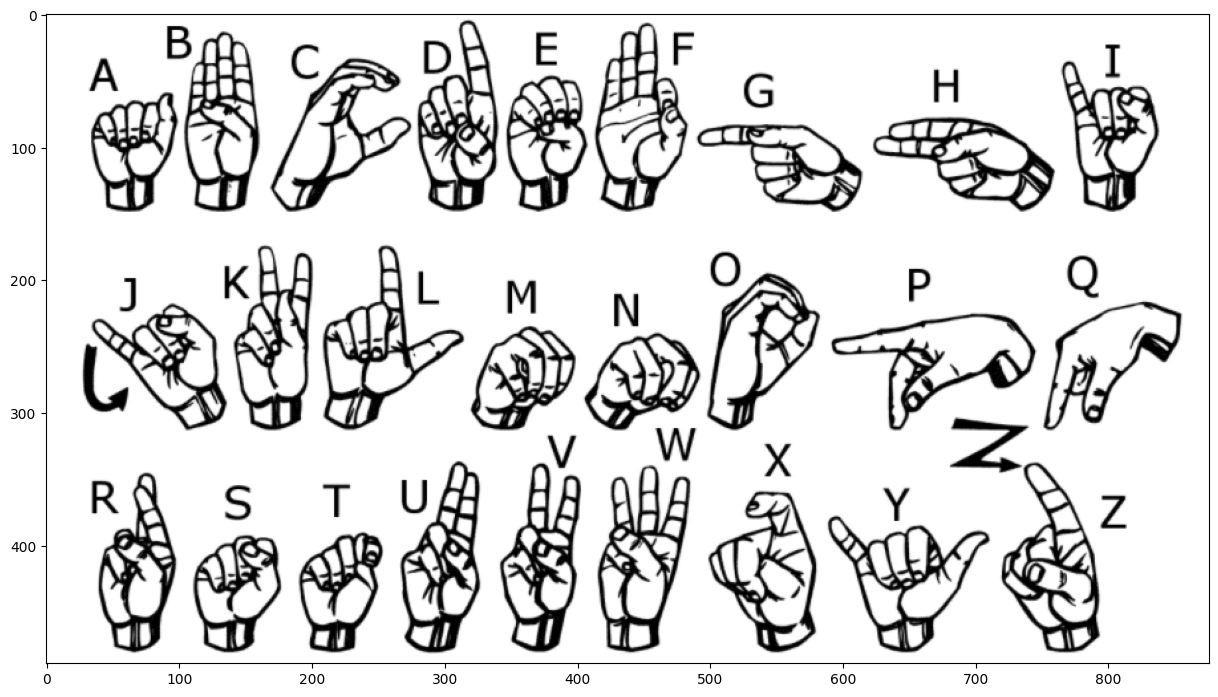

In [6]:
img = mpimg.imread("/american_sign_language.png")
plt.figure(figsize = (15, 12))
plt.imshow(img)

In [8]:
sig_labels = {}
letras = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range (26):
    sig_labels[i] = letras[i]

In [9]:
train_val_set = pd.read_csv("/sign_mnist_train.csv")

train_val_y_df = train_val_set["label"]
train_val_X_df = train_val_set.drop("label", axis = "columns")

train_val_y = train_val_y_df.to_numpy()
train_val_X = train_val_X_df.to_numpy()

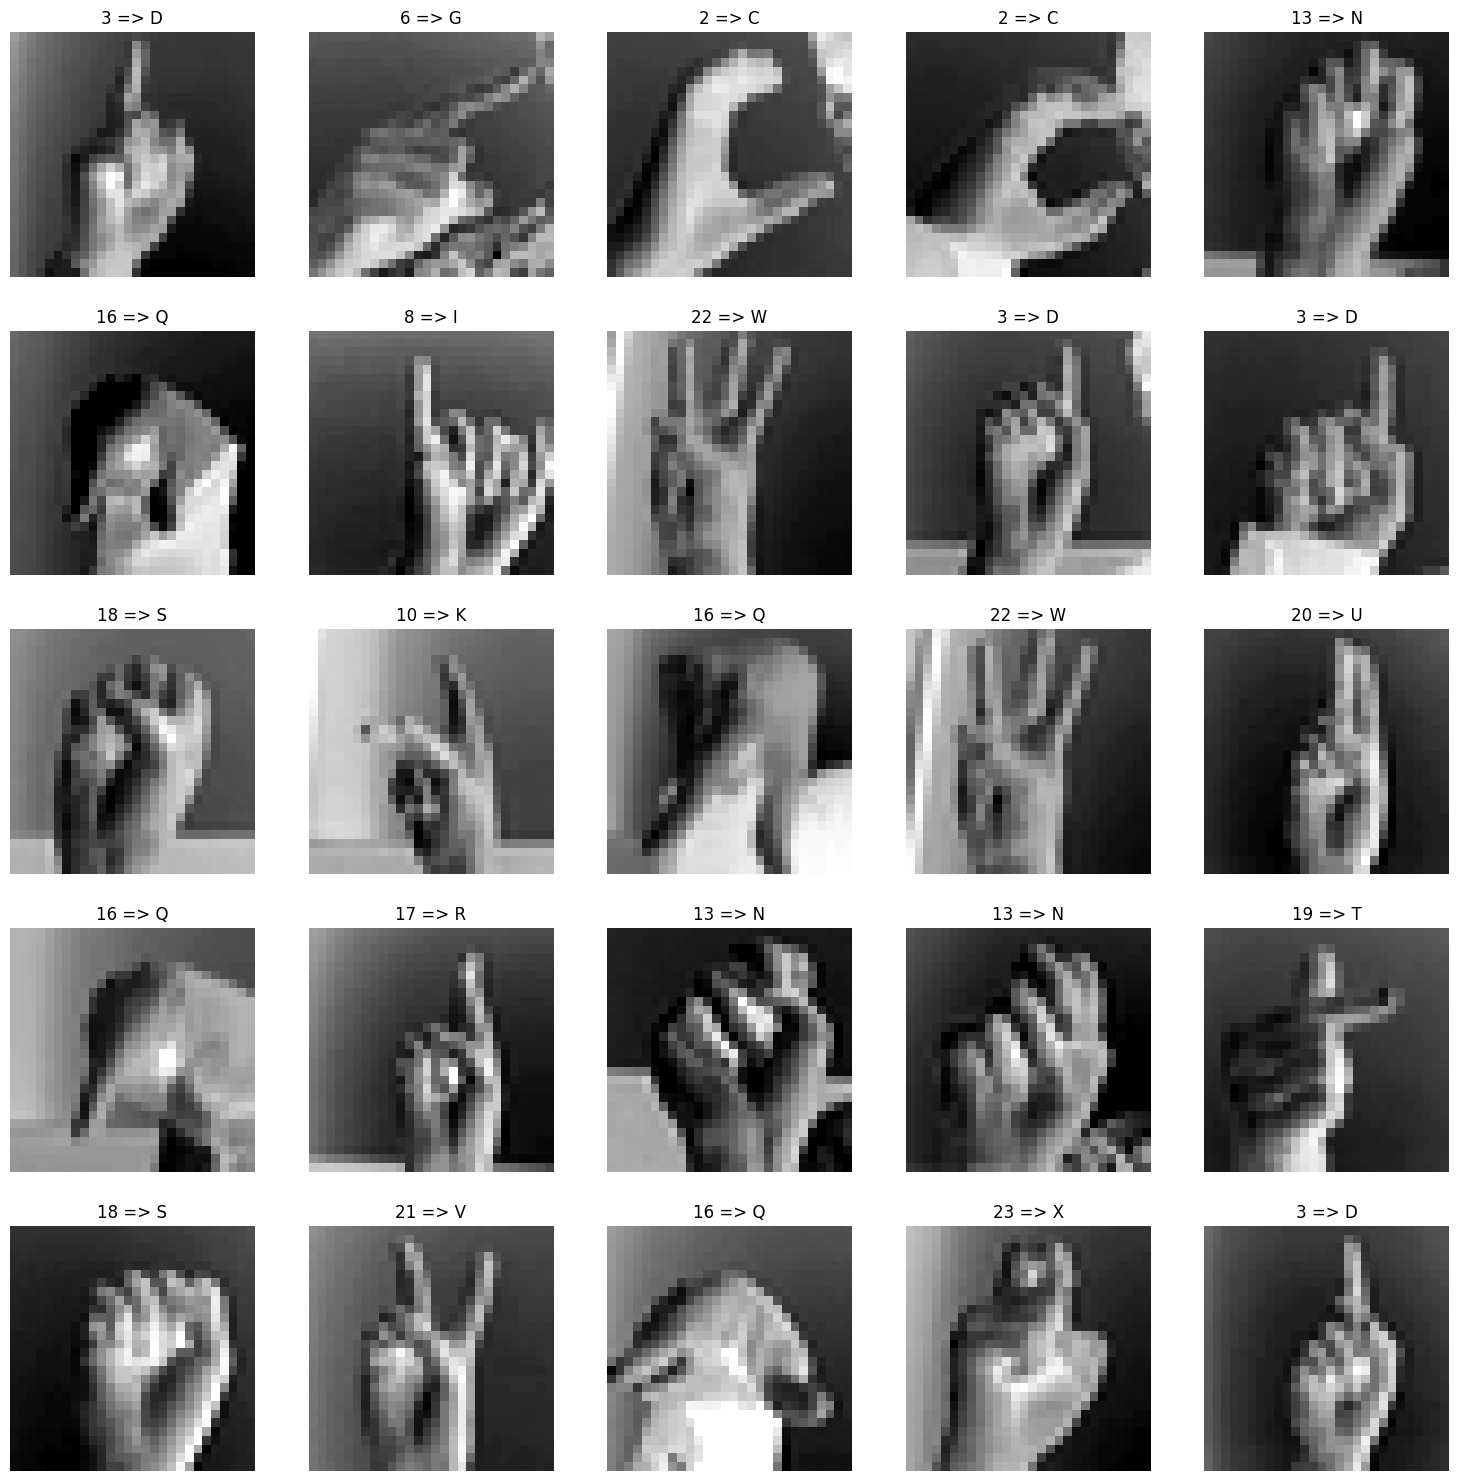

In [15]:
examples25 = train_val_X[0 : 25]

figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0 # row
contc = 0 # column
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(examples25[i].reshape(28, 28), cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(train_val_y[i], sig_labels[train_val_y[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0


In [16]:
train_val_X_for_extension = train_val_X.reshape(27455, 28, 28, 1).copy()

In [17]:
datagen1 = ImageDataGenerator(width_shift_range = 0.15, height_shift_range = 0.1)
X_new_1_raw = datagen1.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

datagen2 = ImageDataGenerator(rotation_range = 20)
X_new_2_raw = datagen2.flow(train_val_X_for_extension, shuffle = False, batch_size = 27455)

In [18]:
X_new_1 = X_new_1_raw[0].copy()
X_new_2 = X_new_2_raw[0].copy()

In [19]:
X_train_val_extended = np.concatenate((train_val_X_for_extension, X_new_1, X_new_2), axis = 0)
y_train_val_extended = np.concatenate((train_val_y, train_val_y, train_val_y))

In [20]:
X_train_val_extended.shape, y_train_val_extended.shape

((82365, 28, 28, 1), (82365,))

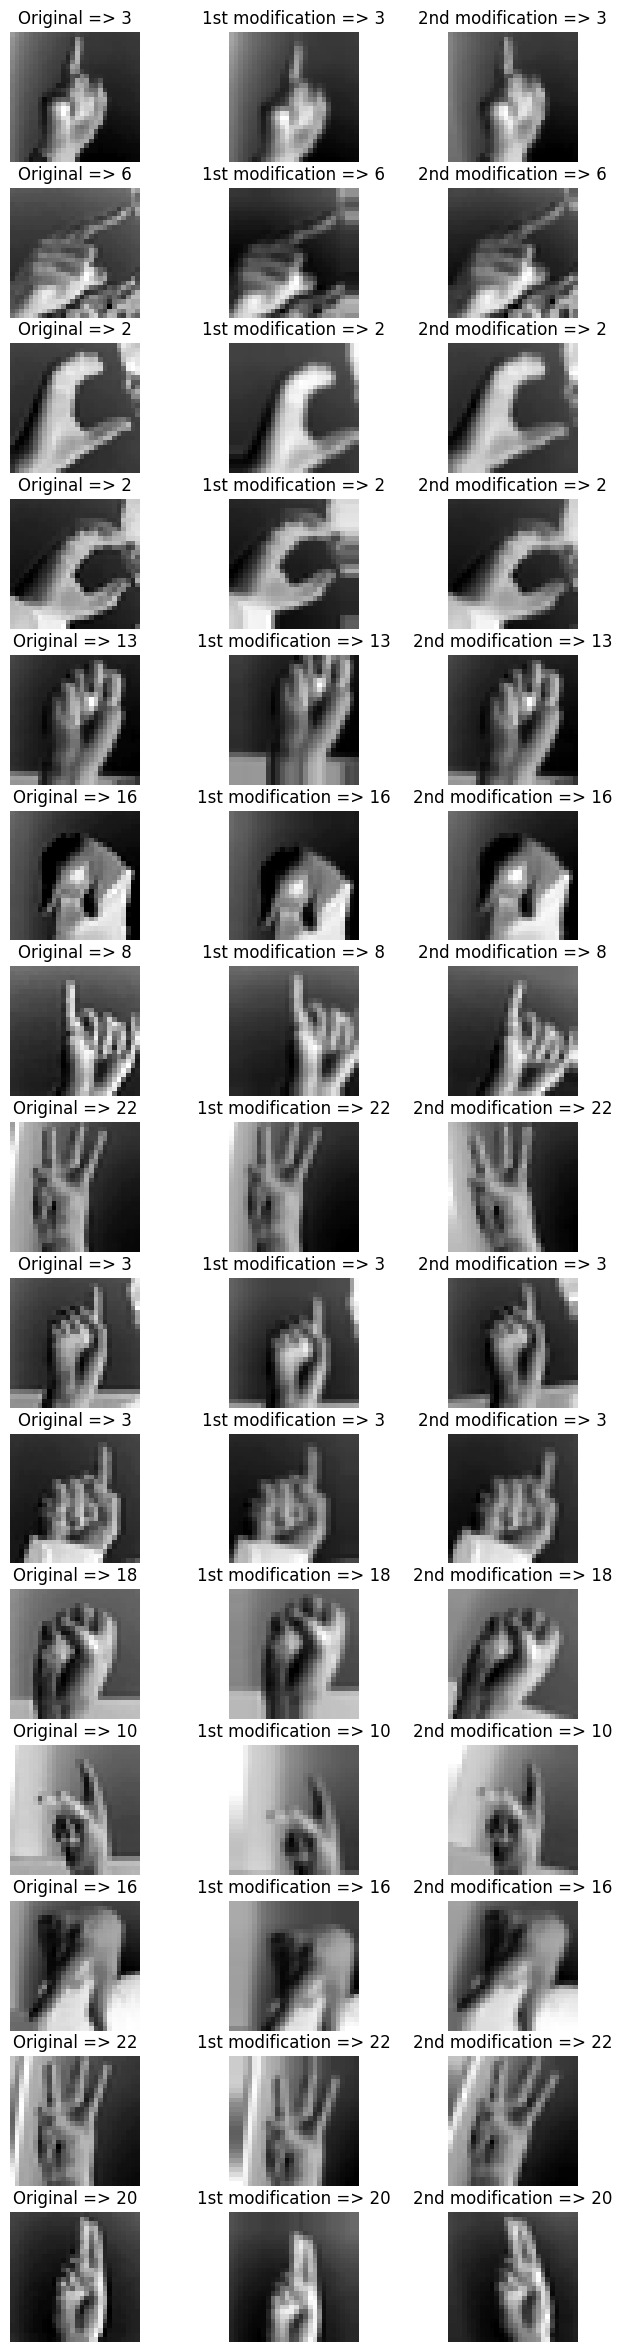

In [21]:
figs, axs = plt.subplots(15, 3, figsize = (8, 30))
contf = 0
contc = 0

for i in range(15):

    axs[i, 0].imshow(X_train_val_extended[i], cmap = mpl.cm.binary)
    axs[i, 0].axis("off")

    axs[i, 1].imshow(X_train_val_extended[27455 + i], cmap = mpl.cm.binary)
    axs[i, 1].axis("off")

    axs[i, 2].imshow(X_train_val_extended[27455 * 2 + i], cmap = mpl.cm.binary)
    axs[i, 2].axis("off")

    axs[i, 0].set_title("Original => %s" %(y_train_val_extended[i]))
    axs[i, 1].set_title("1st modification => %s" %(y_train_val_extended[27455 + i]))
    axs[i, 2].set_title("2nd modification => %s" %(y_train_val_extended[27455 * 2 + i]))


In [22]:
X_train_val_sf , y_train_val_sf = shuffle(X_train_val_extended, y_train_val_extended)

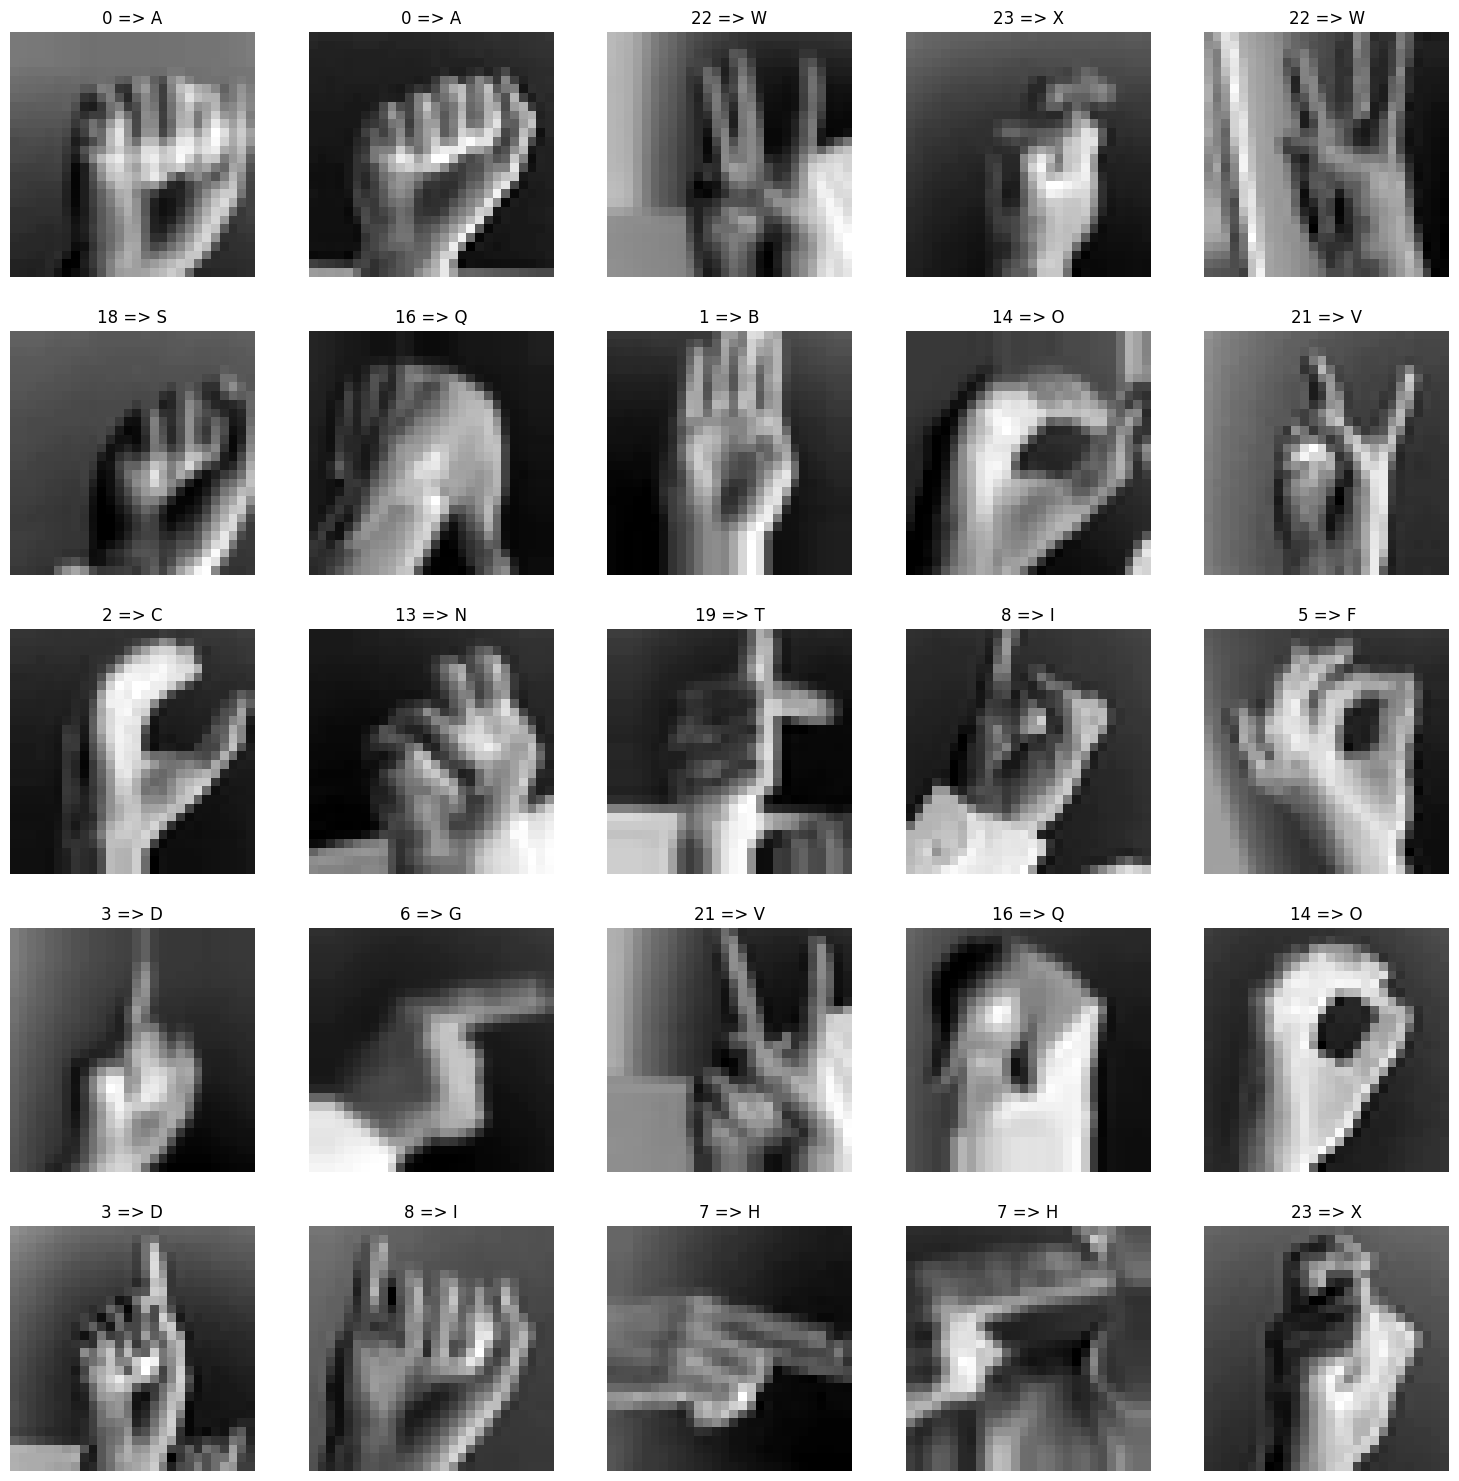

In [23]:
figs, axs = plt.subplots(5, 5, figsize = (15, 15))
contr = 0
contc = 0
figs.tight_layout(pad = 0.5)
for i in range(25):
    axs[contr, contc].imshow(X_train_val_sf[i], cmap = mpl.cm.binary)
    axs[contr, contc].set_title("%s => %s" %(y_train_val_sf[i], sig_labels[y_train_val_sf[i]]))
    axs[contr, contc].axis("off")
    contc += 1
    if contc == 5:
        contr += 1
        contc = 0

In [24]:
X_train = X_train_val_sf[0 : 75000].copy() / 255.0
y_train = y_train_val_sf[0 : 75000].copy()

X_val = X_train_val_sf[75000 : ].copy() / 255.0
y_val = y_train_val_sf[75000 :].copy()


In [25]:
X_train.shape, X_val.shape

((75000, 28, 28, 1), (7365, 28, 28, 1))

In [26]:
CNN = Sequential([

    Conv2D(filters = 64, kernel_size = 7,
           kernel_initializer = "he_uniform", padding = "same",
           input_shape = (28, 28, 1), strides = 1),

    BatchNormalization(),

    Activation("relu"),

    MaxPooling2D(pool_size = 2, padding = "same"),
    # By not specifying strides, it will use the same value as the pool_size, which is 2 in this case.
    # al no poner strides usará el mismo que el pool_size, 2 en este caso

    Conv2D(filters = 128, kernel_size = 3,
           kernel_initializer = "he_uniform", padding = "same",
           strides = 1),

    BatchNormalization(),

    Activation("relu"),

    MaxPooling2D(pool_size = 2, padding = "same"),

    Conv2D(filters = 256, kernel_size = 3,
           kernel_initializer = "he_uniform", padding = "same",
           strides = 1),

    BatchNormalization(),

    Activation("relu"),

    MaxPooling2D(pool_size = 2, padding = "same"),

    #----------------------------------

    Flatten(),

    Dense(units = 240, activation = "relu",
          kernel_initializer = "he_uniform"),

    Dropout(0.5),

    Dense(units = 240, activation = "relu",
          kernel_initializer = "he_uniform"),

    Dropout(0.5),

    Dense(units = 25, activation = "softmax",
          kernel_initializer = "glorot_uniform")

])

In [27]:
CNN.compile(optimizer = "nadam",
               loss = "sparse_categorical_crossentropy",
               metrics = ["accuracy"])

In [29]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("/CNN.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

In [33]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      5

In [35]:
history_CNN = CNN.fit(X_train, y_train, epochs = 20,
                      validation_data = (X_val, y_val),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/20
2344/2344 [==============================] - 19s 8ms/step - loss: 0.0436 - accuracy: 0.9883 - val_loss: 0.0060 - val_accuracy: 0.9989
Epoch 2/20
2344/2344 [==============================] - 19s 8ms/step - loss: 0.0297 - accuracy: 0.9923 - val_loss: 0.8875 - val_accuracy: 0.8200
Epoch 3/20
2344/2344 [==============================] - 21s 9ms/step - loss: 0.0280 - accuracy: 0.9930 - val_loss: 0.0274 - val_accuracy: 0.9890
Epoch 4/20
2344/2344 [==============================] - 19s 8ms/step - loss: 0.0285 - accuracy: 0.9922 - val_loss: 0.0426 - val_accuracy: 0.9886
Epoch 5/20
2344/2344 [==============================] - 19s 8ms/step - loss: 0.0256 - accuracy: 0.9935 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 6/20
2344/2344 [==============================] - 20s 8ms/step - loss: 0.0212 - accuracy: 0.9947 - val_loss: 0.0100 - val_accuracy: 0.9970
Epoch 7/20
2344/2344 [==============================] - 19s 8ms/step - loss: 0.0225 - accuracy: 0.9943 - val_loss: 0.0203 - val_ac

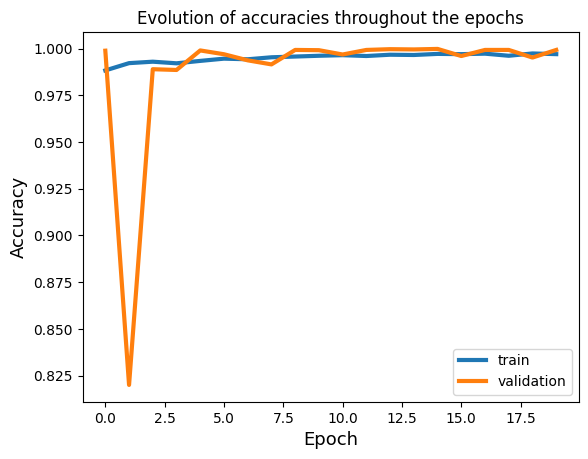

<Figure size 1500x900 with 0 Axes>

In [36]:
plt.plot(history_CNN.history['accuracy'], linewidth = 3)
plt.plot(history_CNN.history['val_accuracy'], linewidth = 3)
#plt.plot(history_CNN.history['loss'], linewidth = 1)
#plt.plot(history_CNN.history['val_loss'], linewidth = 1)
plt.title('Evolution of accuracies throughout the epochs')
plt.ylabel('Accuracy', fontsize = 13)
plt.xlabel('Epoch', fontsize = 13)
plt.legend(['train', 'validation'], loc='lower right')
plt.figure(figsize=(15,9))
plt.show()


In [37]:
CNN.evaluate(X_train, y_train), CNN.evaluate(X_val, y_val)

231/231 [==============================] - 1s 4ms/step - loss: 4.2749e-04 - accuracy: 0.9999


([0.00032587183522991836, 0.9999066591262817],
 [0.00042749210842885077, 0.9998642206192017])

In [39]:
test_set = pd.read_csv("/sign_mnist_test.csv")

test_y_df = test_set["label"]
test_X_df = test_set.drop("label", axis = "columns")

test_y = test_y_df.to_numpy()
test_X = test_X_df.to_numpy()


In [40]:
test_X.shape, test_y.shape

((7172, 784), (7172,))

In [41]:
X_test = test_X.copy().reshape(7172, 28, 28, 1) / 255.0
y_test = test_y.copy()

In [42]:
X_test.shape, y_test.shape

((7172, 28, 28, 1), (7172,))

In [43]:
CNN.evaluate(X_test, y_test)

225/225 [==============================] - 1s 5ms/step - loss: 0.0203 - accuracy: 0.9969


[0.020304029807448387, 0.9969325065612793]

In [44]:
pred_CNN = np.argmax(CNN.predict(X_test), axis = 1)


225/225 [==============================] - 1s 3ms/step


In [45]:
conf_mx = confusion_matrix(y_test, pred_CNN)

In [46]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)


<ipython-input-47-bb324b6a06a4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-47-bb324b6a06a4>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


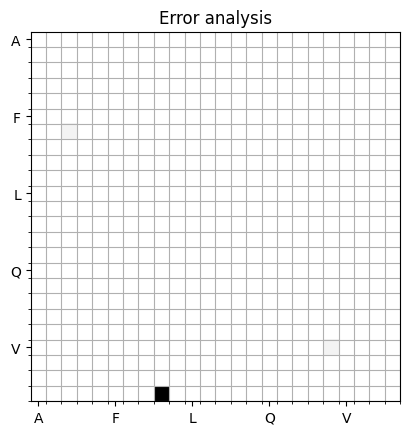

<Figure size 2000x2000 with 0 Axes>

In [47]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
minor_tick = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5,
              11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5,
              20.5, 21.5, 22.5, 23.5, 24.5]
ax.set_xticks(minor_tick, minor=True)
ax.set_yticks(minor_tick, minor=True)
ax.imshow(norm_conf_mx, cmap = plt.cm.gray.reversed())

labels = list("AAFLQV")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.grid(which='minor', alpha=1)

plt.title("Error analysis")
plt.figure(figsize = (20, 20))
plt.show()

In [51]:
CNN.save("/CNN_definitive.h5")